# Previous: document as bag-of-words

* Each word is a one-hot-vector.
* Each document is summation of the words in the document.

# Now: Word Embeddings

1. **Continuous Vector Space:** Unlike the one-hot encoding representation, where each word is a discrete vector with only one element being 1 (indicating the presence of the word), word embeddings place words in a continuous vector space. Each word is represented by a vector of real numbers rather than binary values.
2. **Distributed Representations:** Word embeddings provide distributed representations, meaning the information about a word is spread across multiple dimensions of the vector. This allows capturing semantic relationships and contextual information, as opposed to one-hot encoding where each word is treated in isolation.
3. **Learning through Backpropagation:** Word embeddings are learned during the training of neural networks using backpropagation. In the context of natural language processing, this usually involves training neural networks on large corpora of text data.
4. **Word Similarity in Vector Space:** The objective is to position words with similar meanings or contexts close to each other in the vector space. Similar words should have similar vector representations, facilitating the model to capture semantic relationships.
5. **Co-occurrence Matrix:** To train word embeddings, a co-occurrence matrix is often employed. This matrix keeps track of how often words appear together in a given context or window of text. The idea is that words with similar contexts will have similar embeddings.
6. **Training Process:** During training, the neural network adjusts the word embeddings to minimize the difference between predicted and actual word co-occurrence probabilities. This involves updating the vector representations for words to better capture the underlying patterns in the data.
7. **Applications:** Word embeddings have found applications in various natural language processing tasks such as machine translation, sentiment analysis, and named entity recognition. Pre-trained word embeddings, like Word2Vec, GloVe, and FastText, are often used and fine-tuned for specific tasks due to the computational cost of training large models.

**Example:** For instance, in a well-trained word embedding model, vectors for "king" and "queen" might be close together in the vector space, reflecting their semantic relationship. In summary, word embeddings provide a more nuanced and context-aware representation of words compared to the simplistic one-hot encoding. The use of continuous vector spaces and distributed representations enables models to capture the rich semantic information present in natural language.

In [1]:
import re
import random

# Data for 2-way positive/negative classification instead of 5-way
def load_sst_data(path,
                  easy_label_map={0:0, 1:0, 2:None, 3:1, 4:1}):
    data = []
    with open(path) as f:
        for i, line in enumerate(f):
            example = {}
            example['label'] = easy_label_map[int(line[1])]
            if example['label'] is None:
                continue

            # Strip out the parse information and the phrase labels--
            # ---we don't need those here
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            example['text'] = text[1:]
            data.append(example)

    random.seed(1)
    random.shuffle(data)
    return data

sst_home = 'data/trees/'
training_set = load_sst_data(sst_home + '/train.txt')
dev_set = load_sst_data(sst_home + '/dev.txt')
test_set = load_sst_data(sst_home + '/test.txt')

print('Training size: {}'.format(len(training_set)))
print('Dev size: {}'.format(len(dev_set)))
print('Test size: {}'.format(len(test_set)))

Training size: 6920
Dev size: 872
Test size: 1821


In [4]:
dev_set[:3]

[{'label': 0,
  'text': 'At its worst , it implodes in a series of very bad special effects .'},
 {'label': 1,
  'text': "Awesome creatures , breathtaking scenery , and epic battle scenes add up to another ` spectacular spectacle . '"},
 {'label': 1,
  'text': 'The characters are interesting and often very creatively constructed from figure to backstory .'}]

Next, we'll convert the data to __index vectors__.

To simplify your implementation, we'll use a __fixed unrolling length of 20__. In the conversion process, we'll cut off excess words (towards the left/start end of the sentence), pad short sentences (to the left) with a special word symbol `<PAD>`, and mark out-of-vocabulary words with `<UNK>`, for unknown. As in the previous assignment, we'll use a very small vocabulary for this assignment, so you'll see `<UNK>` often.

In [15]:
import collections
import numpy as np

def sentence_to_padded_index_sequence(datasets):
    '''Annotates datasets with feature vectors.'''

    PADDING = "<PAD>"
    UNKNOWN = "<UNK>"
    SEQ_LEN = 20

    # Extract vocabulary
    def tokenize(string):
        return string.lower().split()

    word_counter = collections.Counter()
    for example in datasets[0]:
        word_counter.update(tokenize(example['text']))

    vocabulary = set([word for word in word_counter if word_counter[word] > 10])
    vocabulary = list(vocabulary)
    vocabulary = [PADDING, UNKNOWN] + vocabulary

    word_indices = dict(zip(vocabulary, range(len(vocabulary))))
    indices_to_words = {v: k for k, v in word_indices.items()}

    for i, dataset in enumerate(datasets):
        for example in dataset:
            example['index_sequence'] = np.zeros((SEQ_LEN), dtype=np.int32)

            token_sequence = tokenize(example['text'])
            padding = SEQ_LEN - len(token_sequence)

            for i in range(SEQ_LEN):
                if i >= padding:
                    if token_sequence[i - padding] in word_indices:
                        index = word_indices[token_sequence[i - padding]]
                    else:
                        index = word_indices[UNKNOWN]
                else:
                    index = word_indices[PADDING]
                example['index_sequence'][i] = index
    return indices_to_words, word_indices

indices_to_words, word_indices = sentence_to_padded_index_sequence([training_set, dev_set, test_set])

In [19]:
{key: indices_to_words[key] for key in list(indices_to_words)[:5]}

{0: '<PAD>', 1: '<UNK>', 2: 'class', 3: 'clearly', 4: 'charm'}

In [50]:
indices_to_words[210], indices_to_words[23] # Will compare this two in the embedding matrix

('brilliant', 'thoughtful')

In [47]:
{key: word_indices[key] for key in list(word_indices)[:5]}

{'<PAD>': 0, '<UNK>': 1, 'class': 2, 'clearly': 3, 'charm': 4}

In [22]:
print(training_set[18])
print(len(word_indices))

{'label': 1, 'text': 'As the dominant Christine , Sylvie Testud is icily brilliant .', 'index_sequence': array([   0,    0,    0,    0,    0,    0,    0,    0,    0,  296, 1216,
          1,    1,  936,    1,    1,  722,    1,  210,  378])}
1250


'index_sequence' array represents the converted version of the text into index vectors. The numbers in this array correspond to the indices of words in a vocabulary. Each number represents a unique word in the sentence.

* For example, the 10th index (296) might correspond to the word 'As', the 11th index (1216) might correspond to 'the', and so on.
* The numbers represent the positions of words in a fixed vocabulary. The use of zero-padding is to ensure that all sequences have the same length (unrolling length of 20 in this case).

# Watching the embedding matrix in a RNN classifier

The self.E variable represents the embedding matrix. Each row in this matrix corresponds to the embedding vector of a specific word in your vocabulary. The columns of each row represent the different dimensions of the embedding space. These dimensions capture various aspects or features of the words. During training, the values in the embedding matrix evolve as the model learns to represent words in a way that helps accomplish the task at hand (in this case, sentiment classification).

**Embedding Matrix (self.E):**

* Dimensions: (vocab_size, embedding_dim)
* vocab_size: The size of your vocabulary, i.e., the number of unique words in your dataset.
* embedding_dim: The chosen dimensionality of the embedding space. Each word is represented as a vector in this space.

In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
tf.__version__

'2.10.0'

In [34]:
def evaluate_classifier(classifier, eval_set):
    correct = 0
    hypotheses = classifier(eval_set)
    for i, example in enumerate(eval_set):
        hypothesis = hypotheses[i]
        if hypothesis == example['label']:
            correct += 1
    return correct / float(len(eval_set))

In [57]:
class RNNSentimentClassifier:
    def __init__(self, vocab_size, sequence_length):
        # Define the hyperparameters
        self.learning_rate = 0.2  # Should be about right
        self.training_epochs = 500  # How long to train for - chosen to fit within class time
        self.display_epoch_freq = 5  # How often to test and print out statistics
        self.dim = 24  # The dimension of the hidden state of the RNN
        self.embedding_dim = 8  # The dimension of the learned word embeddings
        self.batch_size = 256  # Somewhat arbitrary - can be tuned, but often tune for speed, not accuracy
        self.vocab_size = vocab_size  # Defined by the file reader above
        self.sequence_length = sequence_length  # Defined by the file reader above
        self.l2_lambda = 0.001

        self.trainable_variables = []

        # Define the parameters
        self.E = tf.Variable(tf.random.normal([self.vocab_size, self.embedding_dim], stddev=0.1))
        self.trainable_variables.append(self.E)

        self.W_cl = tf.Variable(tf.random.normal([self.dim, 2], stddev=0.1))
        self.b_cl = tf.Variable(tf.random.normal([2], stddev=0.1))
        self.trainable_variables.append(self.W_cl)
        self.trainable_variables.append(self.b_cl)

        # Define the RNN parameters
        self.W_rnn = tf.Variable(tf.random.normal([self.embedding_dim + self.dim, self.dim], stddev=0.1))
        self.b_rnn = tf.Variable(tf.zeros([1, self.dim]))
        self.trainable_variables.append(self.W_rnn)
        self.trainable_variables.append(self.b_rnn)


    def model(self,x):
        # Split up the inputs into individual tensors
        self.x_slices = tf.split(x, self.sequence_length, 1)

        # Define the start state of the RNN
        self.h_zero = tf.zeros([self.batch_size, self.dim])

        # Function that defines one step of an RNN
        def step(x, h_prev):
            #add your code here
            x = tf.reshape(x, [-1])
            emb = tf.nn.embedding_lookup(self.E, x)

            concat = tf.concat([emb, h_prev], axis = 1)

            new_hidden_state = tf.tanh(tf.matmul(concat, self.W_rnn) + self.b_rnn)


            return new_hidden_state

        # Unroll the RNN using a for loop, and obtain the sentence representation with the final hidden state
        h_t = self.h_zero
        for i in range(self.sequence_length):
          h_t = step(self.x_slices[i], h_t)

        sentence_representation = h_t

        # Compute the logits using one last linear layer
        logits = tf.matmul(sentence_representation, self.W_cl) + self.b_cl
        return logits

    def visualize_embedding_matrix(self, epoch):
        # Visualize the input vectors
        plt.figure(figsize=(4, 3))

        # Specify the rows to visualize
        selected_rows = [210, 23]

        # Extract the selected rows from the embedding matrix
        embedding_matrix_slice = self.E.numpy()[selected_rows, :]

        # Plot the selected rows of the embedding matrix
        plt.imshow(embedding_matrix_slice, cmap='viridis', interpolation='nearest', aspect='auto')

        # Adjust the y-axis ticks to show the selected rows
        plt.yticks(range(len(selected_rows)), selected_rows)

        plt.title(f'Embedding Matrix - Epoch {epoch+1}')
        plt.xlabel('Embedding Dimensions')
        plt.ylabel('Word Indices')

        plt.tight_layout()
        plt.show()

    def train(self, training_set, dev_set):
        def get_minibatch(dataset, start_index, end_index):
            indices = range(start_index, end_index)
            vectors = np.vstack([dataset[i]['index_sequence'] for i in indices])
            labels = [dataset[i]['label'] for i in indices]
            return vectors, labels

        print('Training.')

        # Training cycle
        for epoch in range(self.training_epochs):
            random.shuffle(training_set)
            avg_cost = 0.
            total_batch = int(len(training_set) / self.batch_size)

            # Loop over all batches in epoch
            for i in range(total_batch):
                # Assemble a minibatch of the next B examples
                minibatch_vectors, minibatch_labels = get_minibatch(training_set,
                                                                    self.batch_size * i,
                                                                    self.batch_size * (i + 1))

                # Run the optimizer to take a gradient step, and also fetch the value of the
                # cost function for logging
                with tf.GradientTape() as tape:
                  logits = self.model(minibatch_vectors)

                  # Define the L2 cost
                  self.l2_cost = self.l2_lambda * (tf.reduce_sum(tf.square(self.W_rnn)) +
                                                  tf.reduce_sum(tf.square(self.W_cl)))

                  # Define the cost function (here, the softmax exp and sum are built in)
                  total_cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=minibatch_labels, logits=logits) + self.l2_cost)

                # This  performs the main SGD update equation with gradient clipping
                optimizer = tf.optimizers.SGD(self.learning_rate)
                gradients = tape.gradient(total_cost, self.trainable_variables)
                gvs = zip(gradients, self.trainable_variables)
                capped_gvs = [(tf.clip_by_norm(grad, 5.0), var) for grad, var in gvs if grad is not None]
                optimizer.apply_gradients(capped_gvs)

                # Compute average loss
                avg_cost += total_cost / total_batch

            # Display some statistics about the step
            # Evaluating only one batch worth of data -- simplifies implementation slightly
            if (epoch+1) % self.display_epoch_freq == 0:
                tf.print("Epoch:", (epoch+1), "Cost:", avg_cost, \
                    "Dev acc:", evaluate_classifier(self.classify, dev_set[0:256]), \
                    "Train acc:", evaluate_classifier(self.classify, training_set[0:256]))

                # Visualize the embedding matrix every few epochs
                visualize_epoch_freq = 50
                if (epoch+1) % visualize_epoch_freq == 0:
                    self.visualize_embedding_matrix(epoch)

    def classify(self, examples):
        # This classifies a list of examples
        vectors = np.vstack([example['index_sequence'] for example in examples])
        logits = self.model(vectors)
        return np.argmax(logits, axis=1)


Training.
Epoch: 5 Cost: 0.699452162 Dev acc: 0.5546875 Train acc: 0.51953125


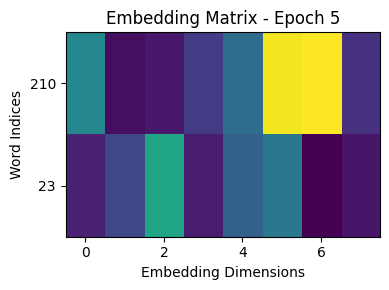

Epoch: 10 Cost: 0.698425233 Dev acc: 0.5546875 Train acc: 0.51171875


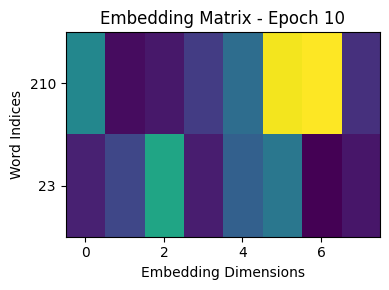

Epoch: 15 Cost: 0.697873652 Dev acc: 0.5546875 Train acc: 0.53125


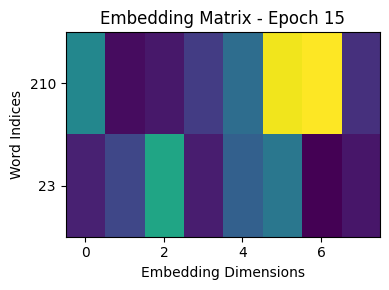

Epoch: 20 Cost: 0.69732511 Dev acc: 0.5546875 Train acc: 0.4765625


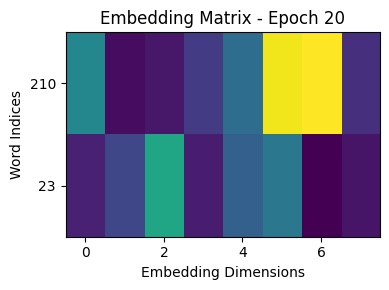

Epoch: 25 Cost: 0.696740866 Dev acc: 0.5546875 Train acc: 0.4921875


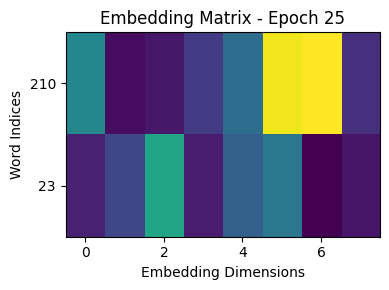

Epoch: 30 Cost: 0.696217537 Dev acc: 0.5546875 Train acc: 0.54296875


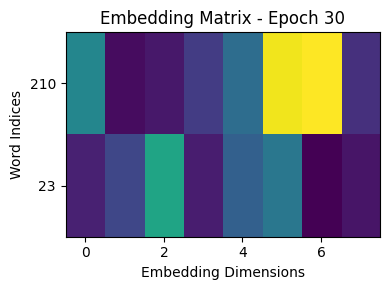

Epoch: 35 Cost: 0.695756674 Dev acc: 0.5546875 Train acc: 0.5234375


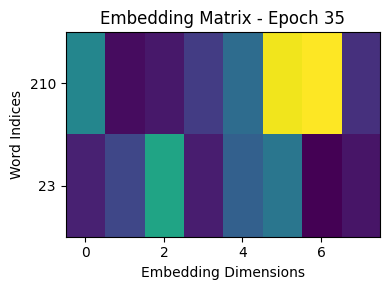

Epoch: 40 Cost: 0.695339143 Dev acc: 0.56640625 Train acc: 0.48046875


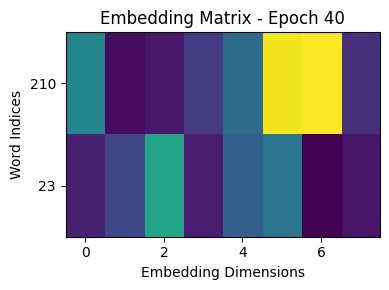

KeyboardInterrupt: 

In [56]:
classifier = RNNSentimentClassifier(len(word_indices), 20)
classifier.train(training_set, dev_set)